### Data loading

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('input'))

input\data2.pickle
['data2.pickle']


In [2]:
# ## Load pickle
# Opening file for reading in binary mode
with open('input/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type
    
with open('y_train.pickle', 'rb') as fr:
    data['y_train'] = pickle.load(fr)

with open('y_validation.pickle', 'rb') as fr:
    data['y_validation'] = pickle.load(fr)

with open('x_train.pickle', 'rb') as fr:
    data['x_train'] = pickle.load(fr)

with open('x_validation.pickle', 'rb') as fr:
    data['x_validation'] = pickle.load(fr)

with open('x_test.pickle', 'rb') as fr:
    data['x_test'] = pickle.load(fr)


In [3]:
# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


### Train

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim 

import torchvision.datasets as datasets  
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
            
        self.conv1 = conv3x3(inplanes, planes, stride)  
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=43, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 100 # input feature map
        self.dilation = 1

        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []

        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion 

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model

def resnet34(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress, **kwargs)

In [7]:
from torch.utils.data import random_split
batch_size = 100

X_train = np.transpose(data['x_train'], (0, 3, 1, 2))
X_train = torch.cuda.FloatTensor(X_train)
Y_train = torch.cuda.LongTensor(data['y_train'])

train_dataset = list(zip(X_train, Y_train))

X_valid = np.transpose(data['x_validation'], (0, 3, 1, 2))
X_valid = torch.cuda.FloatTensor(X_valid)
Y_valid = torch.cuda.LongTensor(data['y_validation'])

valid_dataset = list(zip(X_valid, Y_valid))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
print('train_size :', len(train_dataset))
print('valid_size :', len(valid_dataset))

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_size : 86989
valid_size : 4410


In [19]:
batch_size = 100
num_epoch = 50
lr = 0.001

model = resnet34().to(device=device)
model_opt = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.CosineAnnealingLR(model_opt, T_max=5, eta_min=1e-6)
criterion = nn.CrossEntropyLoss().to(device=device)

train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
for i in range(num_epoch):
    epoch_loss = 0
    predictions = []
    labels = []
    for idx, d in enumerate(train_loader):
        train_x, train_y = d
        x = train_x.to(device=device)
        y= train_y.to(device=device)
        model_opt.zero_grad()
        output = model(x)
        # print(output)
        # print(y)
        loss = criterion(output, torch.max(y,1)[1])
        loss.backward()
        model_opt.step()
        schedular.step()
        epoch_loss += loss.item()
        predictions.append(torch.argmax(torch.nn.functional.softmax(output), dim=-1).detach().cpu().numpy())
        labels.append(torch.max(y,1)[1].detach().cpu().numpy())
    print('Training Epoch', i+1, ' loss:', epoch_loss / (idx+1))
    predictions = np.hstack(predictions)
    labels = np.hstack(labels)   
    train_loss.append(epoch_loss / (idx+1))
    train_acc.append(accuracy_score(labels, predictions))
    print('Accuracy:', accuracy_score(labels, predictions))

    with torch.no_grad():
        epoch_loss = 0
        predictions = []
        labels = []
        for idx, d in enumerate(valid_loader):
            valid_x, valid_y = d
            x = valid_x.to(device=device)
            y= valid_y.to(device=device)
            output = model(x)
            loss = criterion(output, torch.max(y,1)[1])
            epoch_loss += loss.item()
            predictions.append(torch.argmax(torch.nn.functional.softmax(output), dim=-1).detach().cpu().numpy())
            labels.append(torch.max(y,1)[1].detach().cpu().numpy())
        print('Validation Epoch', i+1, ' loss:', epoch_loss / (idx+1))
        predictions = np.hstack(predictions)
        labels = np.hstack(labels)   
        valid_loss.append(epoch_loss / (idx+1))
        valid_acc.append(accuracy_score(labels, predictions))
        print('Accuracy:', accuracy_score(labels, predictions))

Training Epoch 1  loss: 0.9200338277580409
Accuracy: 0.7235282621940705
Validation Epoch 1  loss: 0.6454181849956513
Accuracy: 0.8047619047619048
Training Epoch 2  loss: 0.16188710232361636
Accuracy: 0.9492694478612238
Validation Epoch 2  loss: 0.4814227478371726
Accuracy: 0.8773242630385487
Training Epoch 3  loss: 0.10921153851581374
Accuracy: 0.9658347607168722
Validation Epoch 3  loss: 0.5387035499016444
Accuracy: 0.8678004535147392
Training Epoch 4  loss: 0.07296143201335023
Accuracy: 0.9776983296738668
Validation Epoch 4  loss: 0.46894315911663903
Accuracy: 0.8947845804988662
Training Epoch 5  loss: 0.05689205691437826
Accuracy: 0.9826069962868869
Validation Epoch 5  loss: 0.4480837923785051
Accuracy: 0.9038548752834467
Training Epoch 6  loss: 0.04834400771417248
Accuracy: 0.9853889572244766
Validation Epoch 6  loss: 0.37512838244438174
Accuracy: 0.909750566893424
Training Epoch 7  loss: 0.046225881730219694
Accuracy: 0.9860557081929899
Validation Epoch 7  loss: 0.3721665504905913

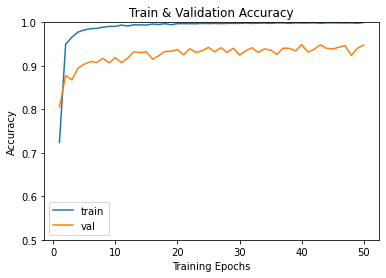

In [24]:
fig , ax = plt.subplots(1)

ax.plot(range(1,num_epoch+1),train_acc,label="train")
ax.plot(range(1,num_epoch+1),valid_acc,label="val")
ax.set_ylabel("Accuracy")
ax.set_ylim([0.5, 1])
ax.set_xlabel("Training Epochs")
ax.set_title('Train & Validation Accuracy')
ax.legend()

plt.show()

### Test

In [21]:
X_test = np.transpose(data['x_test'], (0, 3, 1, 2))
X_test = torch.cuda.FloatTensor(X_test)
test_dataset = list(X_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=True)
print('test_size :', len(test_dataset))

predictions = [];
for idx, test_x in enumerate(test_loader):
    x = test_x.to(device=device)
    output = model(x)
    predictions.append(torch.argmax(torch.nn.functional.softmax(output), dim=-1).detach().cpu().numpy())
predictions = np.hstack(predictions)

test_size : 12630


In [22]:
df = pd.DataFrame(predictions)
df.to_csv('submission.csv', index=False)